# Imports

In [30]:
import pandas as pd
import numpy as np
from PIL import Image
import os

import string 

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from sklearn.svm import LinearSVC

import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from joblib import dump

from sklearn.metrics import classification_report, accuracy_score

# Exploration

## Raw data import 

In [16]:
X = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")
y = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")
X_test = pd.read_csv("../raw_data/test_x.csv", delimiter=" ", index_col="Id")
y_test = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")

In [17]:
X_test

,Image_name,Title
Id,,
0,044310073X.jpg,Oral and Maxillofacial Surgery: An Objective-B...
1,1438005687.jpg,"Barron's GRE, 21st Edition"
2,0060750715.jpg,George Balanchine: The Ballet Maker (Eminent L...
3,1580237959.jpg,"A Partner in Holiness: Deepening Mindfulness, ..."
4,0135137829.jpg,Construction Scheduling: Principles and Practi...
...,...,...
5695,0399174680.jpg,Scandalous Behavior (A Stone Barrington Novel)
5696,1939454654.jpg,Age of Distraction: The Island
5697,1604601604.jpg,The Ghostly Quilts on Main (Colebridge Communi...


In [7]:
y

,Genre_id,Genre_name
Id,,
0,1,Biographies & Memoirs
1,4,Children's Books
2,10,Engineering & Transportation
3,9,Christian Books & Bibles
4,26,Sports & Outdoors
...,...,...
51295,17,"Mystery, Thriller & Suspense"
51296,17,"Mystery, Thriller & Suspense"
51297,17,"Mystery, Thriller & Suspense"


In [8]:
genre_dict = y.set_index('Genre_id')['Genre_name'].to_dict()

## Preliminary Data Preprocessing

In [9]:
array_test = np.array([])

for image_name in X['Image_name'][:5]:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    image_array = np.array(image)

    flattened_pixels = image_array.reshape(-1, 3)
    average_color = np.mean(flattened_pixels, axis=0)
    unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
    most_frequent_index = np.argmax(counts)
    most_frequent_color = unique[most_frequent_index]
    print(most_frequent_color, average_color)

    array_test = np.append(array_test, most_frequent_color)

print(array_test.reshape(-1, 3))

[92 97 74] [144.03354193 144.52836017 126.17757494]
[105 183 222] [121.7903978  155.68775909 171.20017538]
[147   3   3] [121.54918686   8.1564493    7.39793925]
[7 0 0] [193.15625    182.0331832  103.95565609]
[ 81 123 205] [112.07995855 136.00370695 169.8401427 ]
[[ 92.  97.  74.]
 [105. 183. 222.]
 [147.   3.   3.]
 [  7.   0.   0.]
 [ 81. 123. 205.]]


In [109]:
average_colors = []
most_frequent_colors = []

for image_name in X['Image_name']:
    image_path = os.path.join("../raw_data/Images/", image_name)
    image = Image.open(image_path)
    image = image.resize((100, 100))
    image_array = np.array(image)

    flattened_pixels = image_array.reshape(-1, 3)
    average_color = np.mean(flattened_pixels, axis=0)
    unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
    most_frequent_index = np.argmax(counts)
    most_frequent_color = unique[most_frequent_index]

    average_colors.append(average_color)
    most_frequent_colors.append(most_frequent_color)
    
average_colors = np.array(average_colors)
most_frequent_colors = np.array(most_frequent_colors)

In [110]:
colors = np.hstack((average_colors, most_frequent_colors))
extracted_features = pd.DataFrame(colors, columns=["average_r", "average_g", "average_b", "most_freq_r", "most_freq_g", "most_freq_b"])

In [111]:
title_words = np.array(X["Title"].str.split())

count_words = np.array([len(x) for x in title_words])
extracted_features["word_counts"] = count_words

In [112]:
count_words

array([7, 7, 7, ..., 5, 1, 8])

In [113]:
count_capital_letters = lambda s: sum(1 for c in s if c.isupper())

In [114]:
capital_counts = X["Title"].apply(count_capital_letters)

capital_ratio = np.array(capital_counts/count_words)

extracted_features["capital_ratio"] = capital_ratio

In [115]:
count_letters = lambda s: sum(1 for c in s if c.isalpha())

In [116]:
letter_counts = X["Title"].apply(count_letters)

letter_ratio = np.array(letter_counts/count_words)

extracted_features["letter_ratio"] = letter_ratio 

In [117]:
count_punctuation = lambda s: sum(1 for c in s if c in string.punctuation)

In [118]:
punct_counts = X["Title"].apply(count_punctuation)
extracted_features["punct_counts"] = punct_counts

In [119]:
extracted_features

,average_r,average_g,average_b,most_freq_r,most_freq_g,most_freq_b,word_counts,capital_ratio,letter_ratio,punct_counts
0,143.9203,144.4273,126.1171,92.0,97.0,74.0,7,0.857143,5.000000,1
1,121.6648,155.5735,171.1021,105.0,183.0,222.0,7,1.000000,6.857143,4
2,121.4898,8.0966,7.3227,147.0,3.0,3.0,7,1.285714,6.857143,2
3,193.1224,181.9881,103.9752,254.0,134.0,37.0,7,0.857143,5.285714,1
4,112.0715,136.0007,169.8334,81.0,123.0,205.0,11,0.909091,5.090909,4
...,...,...,...,...,...,...,...,...,...,...
51295,144.2605,98.0033,80.7424,255.0,255.0,255.0,2,1.000000,5.500000,0
51296,91.7243,81.9982,50.0007,25.0,23.0,44.0,9,0.777778,5.333333,1
51297,68.6990,63.3906,72.7776,19.0,22.0,27.0,5,0.800000,4.400000,1
51298,118.8070,82.1060,69.3474,56.0,52.0,51.0,1,1.000000,7.000000,0


# Pipeline

## Preprocessing Pipeline

In [18]:
# CREATING CLASS AND ADDING TO PIPELINE
class EmbeddingFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=10, min_count=10, window=5):
        self.vector_size = vector_size
        self.min_count = min_count
        self.window = window
        #self.word2vec_model = None

    def fit(self, X, y=None):
        #self.X_embed = [text_to_word_sequence(str(title)) for title in X['Title']]
        #self.word2vec_model = Word2Vec(vector_size=self.vector_size, min_count=self.min_count, window=self.window)
        #self.word2vec_model.build_vocab(X_embed)
        return self
    
    def transform(self, X):
        X_embed = [word_tokenize(title.lower()) for title in X['Title']]
        word2vec = Word2Vec(sentences=X_embed, vector_size=self.vector_size, min_count=self.min_count, window=self.window)
        title_embeddings_avg = []
        
        for title in X_embed:
            title_embedding = []
            
            for word in title:
                if word in word2vec.wv.key_to_index:
                    word_embedding = word2vec.wv[word]
                    title_embedding.append(word_embedding)
            
            if title_embedding:
                title_embedding_avg = np.mean(title_embedding, axis=0)
                title_embeddings_avg.append(title_embedding_avg)
            else:
                title_embeddings_avg.append(np.zeros(word2vec.vector_size))
                
        title_embeddings_avg = np.array(title_embeddings_avg)
        
        return title_embeddings_avg

In [19]:
class ImageFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        average_colors = []
        most_frequent_colors = []

        for image_name in X['Image_name']:
            image_path = os.path.join("../raw_data/Images/", image_name)
            image = Image.open(image_path)
            image = image.resize((100, 100))
            image_array = np.array(image)

            flattened_pixels = image_array.reshape(-1, 3)
            average_color = np.mean(flattened_pixels, axis=0)
            unique, counts = np.unique(flattened_pixels, return_counts=True, axis=0)
            most_frequent_index = np.argmax(counts)
            most_frequent_color = unique[most_frequent_index]

            average_colors.append(average_color)
            most_frequent_colors.append(most_frequent_color)

        average_colors = np.array(average_colors)
        most_frequent_colors = np.array(most_frequent_colors)
        
        return np.hstack((average_colors, most_frequent_colors))/255

In [20]:
class TitleFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.count_words = lambda s: len(s.split())
        self.count_capital_letters = lambda s: sum(1 for c in s if c.isupper())
        self.count_letters = lambda s: sum(1 for c in s if c.isalpha())
        self.count_punctuation = lambda s: sum(1 for c in s if c in string.punctuation)
        self.count_special_chars = lambda s: sum(1 for c in s if c == ':' or c == '-')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        extracted_features = pd.DataFrame()
        extracted_features['count_words'] = X['Title'].apply(self.count_words)
        extracted_features['capital_ratio'] = X['Title'].apply(lambda s: self.count_capital_letters(s) / self.count_words(s))
        extracted_features['letter_ratio'] = X['Title'].apply(lambda s: self.count_letters(s) / self.count_words(s))
        extracted_features['punct_counts'] = X['Title'].apply(self.count_punctuation)
        extracted_features['special_chars_ratio'] = X['Title'].apply(lambda s: self.count_special_chars(s) / self.count_words(s))
        
        return extracted_features.values

In [21]:

image_pipeline = Pipeline([
    ('image_features', ImageFeatureExtractor()),
])

title_pipeline = Pipeline([
    ('title_features', TitleFeatureExtractor()),
    ('normalize_text', MinMaxScaler())
])

embeddings = Pipeline([
    ('title_embeddings', EmbeddingFeatureExtractor())
])

preprocessing = ColumnTransformer([
    ("image", image_pipeline, ["Image_name"]),
    ("title", title_pipeline, ["Title"]),
    ("embeddings", embeddings, ["Title"])
])

In [22]:
preprocessing

ColumnTransformer(transformers=[('image',
                                 Pipeline(steps=[('image_features',
                                                  ImageFeatureExtractor())]),
                                 ['Image_name']),
                                ('title',
                                 Pipeline(steps=[('title_features',
                                                  TitleFeatureExtractor()),
                                                 ('normalize_text',
                                                  MinMaxScaler())]),
                                 ['Title']),
                                ('embeddings',
                                 Pipeline(steps=[('title_embeddings',
                                                  EmbeddingFeatureExtractor())]),
                                 ['Title'])])

In [23]:
X_preproc = preprocessing.fit_transform(X)
y_preproc = y["Genre_id"]
X_test_preproc = preprocessing.transform(X_test)
y_test_preproc = y_test["Genre_id"]

In [ ]:
#trained_minmax = preprocessing.named_transformers_['title']['normalize_text']

In [ ]:
#dump(trained_minmax, "../models/scalers/baseline_title_feature_minmax_v1.pkl")

# Model

## Cross Validate

In [33]:
model = LinearSVC()

In [34]:
scores = cross_validate(model, X_preproc, y_preproc, cv=5)

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of

In [35]:
score = scores["test_score"].mean()
score

0.2198635477582846

## Train and save model

In [25]:
model = LinearSVC()

In [26]:
model.fit(X_preproc, y_preproc)

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [24]:
#dump(model, "../models/baseline_svc_v1.pkl")

['../models/baseline_svc_v1.pkl']

In [23]:
#X_embed = [word_tokenize(title.lower()) for title in X['Title']]
#word2vec_trained = Word2Vec(sentences=X_embed, vector_size=10, min_count=10, window=5)

In [26]:
#dump(word2vec_trained, "../models/vectorizers/baseline_vectoriser_v1.pkl")

['../models/vectorizers/baseline_vectoriser_v1.pkl']

## Combine Full Pipeline to allow for predictions on unprocessed data

In [27]:
y_pred = model.predict(X_test_preproc)

In [37]:
print(classification_report(y_test_preproc, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.04      0.04       190
           1       0.00      0.00      0.00       190
           2       0.00      0.00      0.00       190
           3       0.09      0.84      0.16       190
           4       0.06      0.45      0.11       190
           5       0.00      0.00      0.00       190
           6       0.08      0.13      0.10       190
           7       0.10      0.01      0.02       190
           8       0.05      0.02      0.02       190
           9       0.00      0.00      0.00       190
          10       0.07      0.03      0.04       190
          11       0.00      0.00      0.00       190
          12       0.00      0.00      0.00       190
          13       0.03      0.03      0.03       190
          14       0.00      0.00      0.00       190
          15       0.00      0.00      0.00       190
          16       0.00      0.00      0.00       190
          17       0.10    

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [38]:
accuracy_score(y_test_preproc, y_pred)

0.07771929824561404

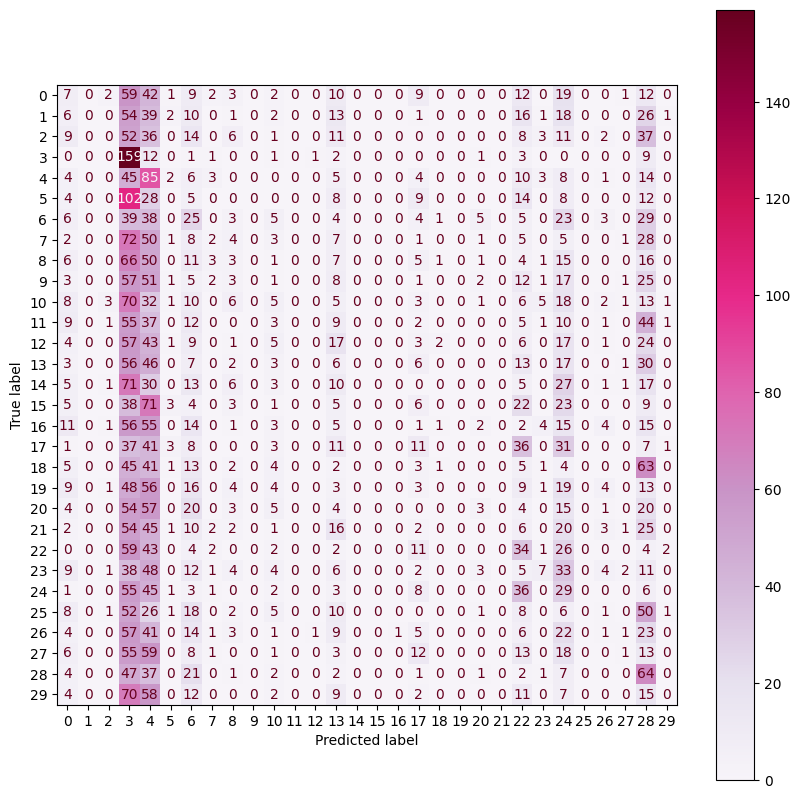

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_preproc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)